<a href="https://colab.research.google.com/github/jonxu88/CodeFromColab/blob/main/Project_Banana_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#This is code following a code along run by Jackie Tan,
#from UpLevel's Data Science Code-Along. 
#See https://www.eventbrite.com.au/x/pythondl-code-along-is-my-banana-ripe-yet-tickets-138204999875

#Given a picture of a banana, classify it as green, overripe, or ripe.

#can get val_accuracy = 0.95 with MobileNetV2
#can get val_accuracy = 0.88 with ResNet50
#VGG16 seems to be a lot worse!!! val_accuracy = 0.36 Why???

!pip install split-folders

In [3]:
import splitfolders

In [4]:
#split folders into training and validation sets
splitfolders.ratio(input="/content/drive/MyDrive/Project Banana Classifier/banana_data",
                   output="/content/drive/MyDrive/Project Banana Classifier/output",
                   seed=2021,
                   ratio=(0.7, 0.15, 0.15)) #0.7 for train, 0.15 for validation, 0.15 for test


Copying files: 450 files [05:46,  1.30 files/s]


In [7]:
import keras
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications import MobileNetV2, ResNet50, VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model #wraps pretrained model and our own stuff later on
from keras.optimizers import Adam



In [40]:
#Can change to MobileNetV2, VGG16, ResNet50 to see what happens
base_model = ResNet50(weights='imagenet', include_top=False) #import the model + remove the last layers

#get the base model's layers
x = base_model.output

# add on our own layers
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) #Introduce a dropout layer to prevent overfitting, kill half the neurons
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

preds = Dense(3, activation='softmax')(x) 
#we have 3 classes: green, ripe, overripe 


94773248/94765736 [==============================] - 3s 0us/step


In [10]:
batch_size = 8 #8 images at a time





In [11]:
#Rescale to something between 0 and 1 --- DOES THIS COMMAND PRODUCE 2^3 AS MUCH TRAINING DATA?
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True
                                   )

test_datagen = ImageDataGenerator(rescale=1./255)


In [12]:
train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Project Banana Classifier/output/train",
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 315 images belonging to 3 classes.


In [13]:
val_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Project Banana Classifier/output/val",
                                                    target_size=(224,224),
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 66 images belonging to 3 classes.


In [14]:
#No augmentation done on test data!
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/Project Banana Classifier/output/test",
                                                  shuffle=False)

Found 68 images belonging to 3 classes.


In [43]:
model = Model(inputs=base_model.input, outputs=preds)

In [44]:
model.compile(optimizer=Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [45]:
history = model.fit(train_generator, steps_per_epoch = train_generator.samples // batch_size,
                    validation_data = val_generator,
                    validation_steps = val_generator.samples // batch_size,
                    epochs=20)

Epoch 1/20
39/39 [==============================] - 17s 309ms/step - loss: 1.1808 - accuracy: 0.4683 - val_loss: 1.1855 - val_accuracy: 0.3281
Epoch 2/20
39/39 [==============================] - 11s 272ms/step - loss: 0.3071 - accuracy: 0.8947 - val_loss: 1.2122 - val_accuracy: 0.3281
Epoch 3/20
39/39 [==============================] - 11s 274ms/step - loss: 0.1973 - accuracy: 0.9064 - val_loss: 1.4300 - val_accuracy: 0.3281
Epoch 4/20
39/39 [==============================] - 11s 275ms/step - loss: 0.3338 - accuracy: 0.9239 - val_loss: 1.2453 - val_accuracy: 0.4844
Epoch 5/20
39/39 [==============================] - 11s 272ms/step - loss: 0.1636 - accuracy: 0.9355 - val_loss: 1.4532 - val_accuracy: 0.3281
Epoch 6/20
39/39 [==============================] - 11s 276ms/step - loss: 0.2188 - accuracy: 0.9534 - val_loss: 1.6018 - val_accuracy: 0.3438
Epoch 7/20
39/39 [==============================] - 11s 278ms/step - loss: 0.1914 - accuracy: 0.9307 - val_loss: 1.2026 - val_accuracy: 0.3594

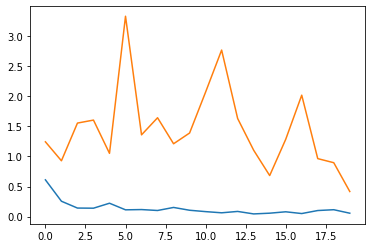

In [23]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [28]:
test_generator.classes # alphabetical order: 'green', 'overripe', 'ripe'

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int32)

In [19]:
from sklearn.metrics import confusion_matrix #assess model performance

In [31]:
predictions = model.predict(test_generator)
predictions #shows that, for example, the first image has 99% chance of green, second has 99%, third has 59% etc.

array([[9.99997497e-01, 6.21264917e-07, 1.90330343e-06],
       [9.99969125e-01, 2.76987066e-07, 3.06784568e-05],
       [9.63746905e-01, 1.21231023e-02, 2.41300836e-02],
       [8.65909040e-01, 1.30956441e-01, 3.13451770e-03],
       [9.97333288e-01, 9.23642481e-04, 1.74301572e-03],
       [9.99978900e-01, 1.23903897e-06, 1.98546895e-05],
       [9.99642015e-01, 1.23508187e-04, 2.34533858e-04],
       [9.89845753e-01, 7.98544716e-05, 1.00743314e-02],
       [9.99962449e-01, 1.26408096e-07, 3.74227784e-05],
       [9.99996185e-01, 7.85788057e-09, 3.83658016e-06],
       [9.99985576e-01, 3.74684905e-09, 1.44172891e-05],
       [9.99998569e-01, 9.21275429e-08, 1.31611750e-06],
       [9.99948740e-01, 3.89298657e-06, 4.72809661e-05],
       [9.79870200e-01, 1.66360103e-02, 3.49375117e-03],
       [9.87477303e-01, 8.59158393e-03, 3.93116241e-03],
       [9.99989390e-01, 2.70988807e-07, 1.03834227e-05],
       [9.93144274e-01, 2.17527663e-03, 4.68037231e-03],
       [9.99888539e-01, 1.09423

In [32]:
import numpy as np
single_pred = np.argmax(predictions, axis = 1) #takes the predictions above and tells us which is maximum
single_pred 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2])

In [33]:
confusion_matrix(test_generator.classes, single_pred) #If our model is perfect, we would have a diagonal matrix
#So our model predicts green very well, but not the overripe
#                           Predicted
#                     green overripe ripe
#           green
#Actual     overripe
#           ripe

array([[22,  0,  0],
       [ 0, 20,  3],
       [ 0,  1, 22]])